# POS Tagging

Get the Brown corpus.

In [1]:
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Get the tokenized and tagged with Universal POS sentences from the "news" category from the Brown corpus:

In [2]:
from nltk.corpus import brown
nltk.download('universal_tagset')
brown_sents = brown.tagged_sents(categories='news', tagset='universal')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


See an example

In [3]:
brown_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

## Split into train and test
Use all but the last 1000 sentences to train the classifier. (It should be better to choose them randomly).

In [4]:
brown_train = brown_sents[:-1000]
brown_test = brown_sents[-1000:]

## Build dictionary of words and tags

Vocabularies of words and tags:

In [5]:
word_set = set()
tag_set = set()
for sentence in brown_sents:
    for word, tag in sentence:
        word_set.add(word)
        tag_set.add(tag)

Dictionaries of words and tags:

In [6]:
word_index = {}
for idx, word in enumerate(word_set):
    word_index[word] = idx + 2 # leave 0 and 1 for padding and unknown
    
tag_index = {}
int2tag = {}
for idx, tag in enumerate(tag_set):
    tag_index[tag] = idx
    int2tag[idx] = tag

n_words = len(word_index) + 2 # for padding and OOV
n_tags = len(tag_set)

See the tag set of Universal Dependencies:

In [7]:
tag_set

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

We represent each word as an n-gram of a few tokens around the word.

In [8]:
import numpy as np

def build_ngrams(sentences, ctx_size, word_index, tag_index):
    """
    Turn sentences into n-grams of word indices, taken from word_index.
    :param setences: a list of sentences.
    :param ctx_size: numer of tokens to consider before and after each word.
    :param word_index: dictionary of words.
    :param tag_index: dictionary of tags.
    :return: the list of n-grams and the list of corresponding labels.
    """
    padding_idx = 0
    unknown_idx = 1
    
    X = []
    Y = []
    
    for sentence in sentences:
        for n, (word, tag) in enumerate(sentence):
            word_indices = []
            for i in range(n - ctx_size, n + ctx_size + 1):
                # add padding
                if i < 0 or i >= len(sentence):
                    word_indices.append(padding_idx)
                    continue
                gram = sentence[i][0]
                # index of either word, lowercase word or unknown
                word_idx = word_index.get(gram) or word_index.get(gram.lower(),
                                                                  unknown_idx)
                word_indices.append(word_idx)

            X.append(word_indices)
            Y.append(tag_index[tag])
            
    return np.asarray(X), np.asarray(Y)                    

## Build the data set of n-grams

In [9]:
ctx_size = 2
window_size = 2 * ctx_size + 1
x_train, y_train = build_ngrams(brown_train, ctx_size, word_index, tag_index)
x_test, y_test = build_ngrams(brown_test, ctx_size, word_index, tag_index)

In [10]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((77552, 5), (77552,), (23002, 5), (23002,))

Turn tags into a one-hot representation:

In [12]:
from keras.utils import to_categorical
to_categorical?

Signature: to_categorical(y, num_classes=None)
Docstring:
Converts a class vector (integers) to binary class matrix.

E.g. for use with categorical_crossentropy.

# Arguments
    y: class vector to be converted into a matrix
        (integers from 0 to num_classes).
    num_classes: total number of classes.

# Returns
    A binary matrix representation of the input.
File:      /usr/local/lib/python3.6/dist-packages/keras/utils/np_utils.py
Type:      function


Convert outputs to one-hot vectors, so that the classifier will produce a probability distribution for each tag: 

In [13]:
y_train_cat = to_categorical(y_train, num_classes=n_tags)
y_test_cat = to_categorical(y_test, num_classes=n_tags)

In [14]:
x_train.shape, y_train_cat.shape, x_test.shape, y_test_cat.shape

((77552, 5), (77552, 12), (23002, 5), (23002, 12))

See one result in categorical form:

In [15]:
y_train[0], y_train_cat[0]

(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### Build the model

In [16]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dropout, Dense
from keras.losses import binary_crossentropy, categorical_crossentropy

Hyperparameters

In [21]:
MAX_SEQUENCE_LENGTH = 250
HIDDEN_SIZE = 128
EMBEDDING_DIM = 50
EPOCHS = 4
BATCH_SIZE = 64

In [18]:
model = Sequential()
model.add(Embedding(n_words, EMBEDDING_DIM, input_length=window_size))
model.add(Flatten())
model.add(Dropout(0.2)) # optional
model.add(Dense(HIDDEN_SIZE, activation='relu'))
model.add(Dropout(0.2)) # optional
model.add(Dense(n_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

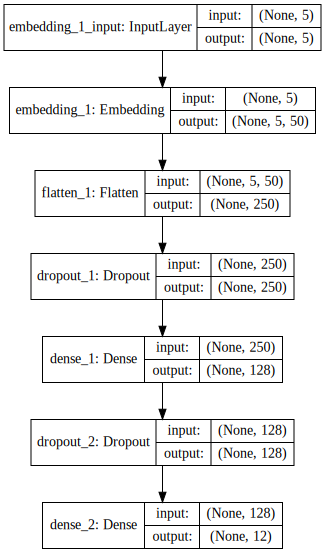

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train the model

In [22]:
history = model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
77552/77552 [==============================] - 14s 177us/step - loss: 0.5266 - acc: 0.8459
Epoch 2/4
77552/77552 [==============================] - 14s 176us/step - loss: 0.0952 - acc: 0.9715
Epoch 3/4
77552/77552 [==============================] - 14s 176us/step - loss: 0.0411 - acc: 0.9874
Epoch 4/4
77552/77552 [==============================] - 14s 175us/step - loss: 0.0242 - acc: 0.9929


### Evaluate the tagger
`predict_classes` returns the `argmax` of the predicted `softmax` scores.

In [23]:
y_pred = model.predict_classes(x_test)

This is equivalent of calling `predict` to obtain a probability distribution and then taking the `argmax`:

In [24]:
y_pred_cat = model.predict(x_test)
y_pred == y_pred_cat.argmax(1)

array([ True,  True,  True, ...,  True,  True,  True])

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_micro_avg(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred) * 100
    pr = precision_score(y_test, y_pred, average='micro') * 100
    rc = recall_score(y_test, y_pred, average='micro') * 100
    f1 = f1_score(y_test, y_pred, average='micro') * 100
    print("Accuracy: %.2f, Precision: %.2f, Recall: %.2f, F1: %.2f" %
          (acc, pr, rc, f1))

In [26]:
show_micro_avg(y_test, y_pred)

Accuracy: 93.39, Precision: 93.39, Recall: 93.39, F1: 93.39


### Show the confusion matrix

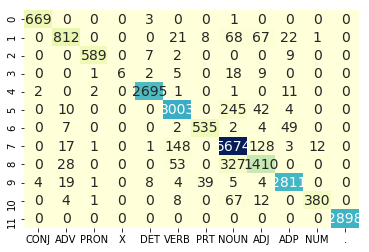

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

import seaborn as sn
import pandas as pd
%matplotlib inline

df = pd.DataFrame(cm, columns=tag_set)
sn.heatmap(df, annot=True, cbar=False, fmt="d", cmap="YlGnBu", annot_kws={"size": 14})# font size

## POS Tagger with Conv1D
Instead of creating the ngrams explicitly, one could use a `Conv1D` layer to group tokens. 

In [28]:
unknown_idx = 1
x_train = [[word_index.get(word.lower(), unknown_idx)
            for word,tag in sentence] for sentence in brown_train]
y_train = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_train]
x_test = [[word_index.get(word.lower(), unknown_idx)
                    for word,tag in sentence] for sentence in brown_test]
y_test = [[tag_index[tag] for word,tag in sentence]
                                       for sentence in brown_test]

In [29]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_train = pad_sequences(y_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_test = pad_sequences(y_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [30]:
y_train_cat = to_categorical(y_train, num_classes=n_tags)
y_test_cat = to_categorical(y_test, num_classes=n_tags)

### Build the model

In [32]:
filters = 16

model = Sequential()
model.add(Embedding(n_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters, window_size, padding='same', activation='relu'))
#model.add(MaxPooling1D(window_size))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_tags, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

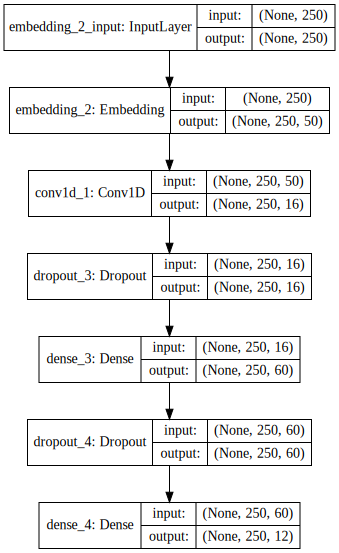

In [33]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [34]:
history = model.fit(x_train, y_train_cat, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
3623/3623 [==============================] - 3s 847us/step - loss: 1.3667 - acc: 0.8887
Epoch 2/4
3623/3623 [==============================] - 3s 769us/step - loss: 0.1835 - acc: 0.9415
Epoch 3/4
3623/3623 [==============================] - 3s 779us/step - loss: 0.1276 - acc: 0.9598
Epoch 4/4
3623/3623 [==============================] - 3s 774us/step - loss: 0.0948 - acc: 0.9685


In [35]:
y_pred = model.predict_classes(x_test)

Convert label ids to labels and use them for sklearn's reports

In [36]:
def y2label(gold, pred, pad=0):
    out_true = []
    out_pred = []
    for a, b in zip(gold, pred):
        if a != pad: # Exclude -PAD- term
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [37]:
yl_true, yl_pred = y2label(y_test.flat, y_pred.flat)

# Classification report

In [38]:
from sklearn.metrics import classification_report

In [39]:
print(classification_report(yl_true, yl_pred, digits=4))

              precision    recall  f1-score   support

           .     0.9969    0.9907    0.9938      2898
         ADJ     0.0000    0.0000    0.0000      1818
         ADP     0.5110    0.9751    0.6705      2895
         ADV     0.0000    0.0000    0.0000       999
        CONJ     0.0000    0.0000    0.0000         0
         DET     0.6208    0.1515    0.2436      2712
        NOUN     0.6713    0.9821    0.7975      5984
         NUM     0.0000    0.0000    0.0000       472
        PRON     0.0000    0.0000    0.0000       607
         PRT     0.0000    0.0000    0.0000       599
        VERB     0.7714    0.8611    0.8138      3304
           X     0.0000    0.0000    0.0000        41

   micro avg     0.6640    0.6640    0.6640     22329
   macro avg     0.2976    0.3300    0.2933     22329
weighted avg     0.5651    0.6640    0.5796     22329



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# POS Tagger based on Maximum Entropy Memory Model 

In [16]:
import numpy as np
import re
from nltk.classify.maxent import MaxentClassifier

### The feature extractor
The MaxEnt classifiers relies on hand crafted feature representations for the input words.

The features we use:
<ul>
    <li>morphological aspects of English words, e.g. words ending in 'ed', 'ing', or 'ly'</li>
    <li>capitalization, not at the beginning of a sentence</li>
    <li>presence of the word in a list of closed POS categories, e.g. 'CONJ', 'DET', 'PRON', 'PRT</li>
    <li>aspects of the previos word: e.g capitalization, particle</li>
</ul>
You can think of many such features.

Until a few years ago, the SoTA POS taggers were using a rich feature set. See for example:

Giménez, J., and Márquez, L. 2004. [SVMTool: A general POS tagger generator based on Support Vector Machines](https://www.cs.upc.edu/~nlp/SVMTool/lrec2004-gm.pdf]). Proceedings of LREC'04. Lisbon, Portugal.

Compute the most common suffixes:

In [17]:
suffix_fdist = nltk.FreqDist()
for word in brown.words():
     word = word.lower()
     suffix_fdist[word[-2:]] += 1
     suffix_fdist[word[-3:]] += 1

common_suffixes = [suffix for (suffix, count) in suffix_fdist.most_common(20)]

Collects the feature of a word at position n in a sentence

In [147]:
def features_dict(word, prev_word, prev_tag, n, lexicon):
    """
    :param word: the current word
    :param prev_word: the preceding word, or None if it soes not exist
    :param prev_tag: the tag of the previous word
    :param n: the position of the wird in the sentence
    :param lexicon: a lexicon of POS for each word
    :return: a dictionary of features {feature: value}
    """
    word = word.lower()
    prev_word = prev_word.lower() if prev_word else ''
    DET = lexicon['DET']
    CONJ = lexicon['CONJ']
    PRON = lexicon['PRON']
    PRT = lexicon['PRT']

    features = {
        'wi': word,
        'wi-1': prev_word,
        'CurCap': is_cap(word),
        'FirstWord': n == 0,
        'HasNumb': has_number(word),
        'Article': word in DET,
        'PrevArticle': prev_word in DET,
        'Conj': word in CONJ,
        'Pron': word in PRON,
        'Prt': word in PRT,
        'PrevConj': prev_word in CONJ,
        'PrevPrt': prev_word in PRT,
        'PrevTag': prev_tag   # required to compute transition probabilities
    }
    for suffix in common_suffixes:
        if word.endswith(suffix):
            features['endswith({})'.format(suffix)] = 1
    # presence in given POS list
    for tag, words in lexicon.items():
        if word in words:
            features[tag] = 1
    return features

Features

In [148]:
def is_cap(word):
    return word[0].isupper()

def has_number(word):
    return re.search(r'\d+', word) is not None

In [149]:
def create_featuresets(sentence, lexicon):
    """
    Build a featureset for each token in a sentence, for use in training a MaxentClassifier.
    :param sentence: a list of pairs (word, tag).
    :return: a list of pairs (featurset, tag)
    """
    for n, (word, tag) in enumerate(sentence):
        prev_word = sentence[n-1][0] if n > 0 else None
        prev_tag = sentence[n-1][1] if n > 0 else None
        yield (features_dict(word, prev_word, prev_tag, n, lexicon), tag)


In [150]:
from collections import defaultdict

def create_lexicon(trainset, tags=('ADV', 'DET', 'PRON', 'PRT')):
    """
    Build lexicon of words belonging to specific closed categories.
    """
    lexicon = defaultdict(set)
    for sent in trainset:
        for w,t in sent:
            if t in tags:
                lexicon[t].add(w)
    return lexicon

## MaxEntropy Memory Model Tagger

In [151]:
from nltk.classify.maxent import MaxentClassifier

class MemmTagger():
    
    def __init__(self, trainset, max_iter=25):
        """
        :param trainset: list of sentences, each a list of pairs (word, tag)
        """
        self.tags = list(set((tag for sent in trainset for word,tag in sent )))
        self.lexicon = create_lexicon(trainset)
        train_examples = [pair for sentence in trainset for pair in create_featuresets(sentence, self.lexicon)]
        self.classifier = MaxentClassifier.train(train_examples, max_iter=max_iter)
        self.train_examples = train_examples # DEBUG
    
    def tag(self, sentence):
        tags = self.viterbi(sentence)
        return list(zip(sentence, tags))
    
    def viterbi(self, words):
        """
        Returns the tag sequence of the optimal (most probable) path through
        the MEMM. Uses the Viterbi algorithm to calculate this path by dynamic
        programming.

        :return: the tag sequence
        :rtype: sequence of any
        :param words: the sequence of word indices
        :type words: list of str
        """
        T = len(words)
        N = len(self.tags)

        V = np.zeros((T, N), np.float32)
        B = -np.ones((T, N), np.int)

        featuresets = create_featuresets(words, self.lexicon)
        P = [ self.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
        
        # the forward probability: s1 = previous label, s2 = next label
        # A[t, s2] = Sum{s1} A[t-1, s1] * p(s2| s1,o_t)
        # P[t/s1].prob(s2) = p(s2| s1,o_t)
        # where P[t/s1] is the dist prob at t if previous tag was s1
        # A[t, s2] = sum(A[t-1, s1] * P[t/s1].prob(s2) forall s1)
        A = np.zeros(N)
        for s in range(N):
            A[s] = P[0].logprob(s)
                
        V[0] = A
        for t in range(1, T):
            # build transition probabilities
            A1 = np.zeros(N)
            for s in range(N):
                A1[s] = sum([A[s1] + self.prob_from_tag(featureset[t], s1).logprob[s] for s1 in range(N)])
            A = A1
            for s in range(N):
                vs = V[t - 1, :] + A
                best = np.argmax(vs)
                V[t, s] = vs[best] + P[t].logprob(s)
                B[t, s] = best

        current = np.argmax(V[T - 1, :])
        tags = [current]
        for t in range(T - 1, 0, -1):
            last = B[t, current]
            tags.insert(0, last)
            current = last

        return list(map(self.tags.__getitem__, tags))

                            
    def prob_from_tag(self, featureset, prev_tag):
        """
        Calculate the probability distribution of featureset when the previous tag is :param prev_tag:
        """
        cur_tag = featureset['PrevTag'] # save
        featureset['PrevTag'] = self.tags[prev_tag]
        prob_dist = self.classifier(featurset)
        featureset['PrevTag'] = cur_tag # restore
        return prob_dist

## Train the Maximum Entropy Memory Model

<b>Warning</b>: training is quite slow.

In [152]:
tagger = MemmTagger(brown_train, max_iter=20)

  ==> Training (20 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.48491        0.001
             2          -1.35686        0.531
             3          -1.09917        0.637
             4          -0.93441        0.731
             5          -0.81685        0.804
             6          -0.72837        0.840
             7          -0.65944        0.857
             8          -0.60426        0.870
             9          -0.55907        0.884
            10          -0.52133        0.894
            11          -0.48927        0.903
            12          -0.46165        0.913
            13          -0.43755        0.919
            14          -0.41630        0.924
            15          -0.39739        0.929
            16          -0.38043        0.936
            17          -0.36510        0.940
            18          -0.35117        0.943
            19          -0.33843        0.946
  

In [ ]:
tag_pred = [tagger.tag(sent) for sent in brown_test]

# Conclusions

Draw your conclusions about sequence tagging using either plain NN, NN with embrddings, CNN or Maximum Entropy using hand crafted features.

In [153]:
# Why the classifer returns always 0?
sent = brown_train[0]
featuresets = create_featuresets(sent, tagger.lexicon)
P = [ tagger.classifier.prob_classify(featureset) for (featureset, label) in featuresets ]
[P[1].prob(i) for i in range(len(tagger.tags))]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]